# DeepSI -- Jupyter

Please refer to [DeepSI](https://dl.acm.org/doi/10.1145/3397481.3450670) for details.



## Requirements:
- Software 
    - Pytorch
    - SKLearn
    - Transformers 
    - Numpy
    - Pandas

- Hardware: 
    - GPU: 2080 TI +
    - CUDA

In [1]:
%matplotlib notebook

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from torch.optim import Adam

import re
import torch
from transformers import BertTokenizer

from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier

import torch
from torch import nn
from torch.nn import functional as F

from transformers import BertModel
from transformers import BertTokenizer

import torch
from transformers import BertTokenizer, BasicTokenizer


import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


from abc import ABC

from scipy.spatial.distance import squareform
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import statistics
import numpy as np

## Gloal Variables 

In [2]:
# Create a tokenizer to tokenize text data, breaking it into subword tokens that later be fed into BERT model. Case-insensitive
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Data Preprocessing

- Data Loading: using covid-19 data about 4 risk factors as default
- Text Cleaning, Tokenizing & Embedding

### Data Loading

- raw_texts,
- texts,
- ids, 
- labels

### Tasks

In [3]:
def load_covid(corpus_path='./data/cord-19/risk_factors.csv'):
    def get_label(row):
        risk_factor = row['risk_factor']
        if risk_factor == 'cancer':
            return 0

        if risk_factor == 'kidney':
            return 1

        if risk_factor == 'neuro':
            return 2

        return 3

    df = pd.read_csv(corpus_path)

    raw_texts = []
    texts = []
    ids = []
    labels = []

    for index, row in df.iterrows():
        text = row['title'] + ' ' + row['abstract']
        raw_texts.append(text)
        # texts.append(clean_str(clean_tweet(text)))
        texts.append(text)
        ids.append(row['cord_uid'])
        labels.append(get_label(row))
    return raw_texts, texts, ids, labels


### Data Preprocess

In [4]:
def tokenize_corpus(x):
    """
    transform documents, and their labels into tensordataset, based on tokenizer
    """
    # Initializing the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    
    print('max_length of texts: ', max([len(i) for i in x]))

    # Tokenization
    # Special Tokens: [CLS] and [SEP], Classifer and Separator
    tokenized_output = tokenizer.batch_encode_plus(x,
                                                   add_special_tokens=True,
                                                   # max_length=max_length,
                                                   truncation=True,
                                                   pad_to_max_length=True)
    
    # Converting Tokenized Output to Tensors
    # input_ids (torch.LongTensor of shape (batch_size, sequence_length), optional) – The sequence used as a prompt for the generation. If None the method initializes it as an empty torch.LongTensor of shape (1,).
    input_ids = torch.tensor(tokenized_output['input_ids'])
    print('input_ids: ', input_ids)
    # attention_mask (torch.Tensor) – Mask with ones indicating tokens to attend to, zeros for tokens to ignore.
    attention_masks = torch.tensor(tokenized_output['attention_mask'])
    print('attention_masks: ', attention_masks)
    print('max_length of texts: ', max([len(i) for i in input_ids]))

    return input_ids, attention_masks


In [5]:
class Sample:
    def __init__(self,
                 text,
                 input_id,
                 attention_mask,
                 position=(0.0, 0.0),
                 label=None,
                 id=None,
                 raw_text=None,
                 ):
        """
        Everything need for Visualization about each of the sample.
        """
        self.text = text
        self.input_id = input_id
        self.attention_mask = attention_mask

        self.position = position  # default position in 2d spatialization

        self.distances = None
        self.label = label
        self.id = id
        self.raw_text = raw_text
        self.representation = None

    def to_dict(self, i=0):
        return {
            'id': i if self.id is None else self.id,
            'text': self.raw_text if self.raw_text else self.text,
            'words': self.words,
            'position': self.position,
            'init': True,
            'label': self.label,
        }


class SamplesForTraining:
    def __init__(self, input_ids, attention_masks, positions):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.positions = positions


class Samples:
    def __init__(self,
                 raw_texts,
                 texts,
                 ids,
                 labels=None,):
        """
        Control how to manipulate samples, and provide models with features
        """
        self.raw_texts = raw_texts
        self.texts = texts
        self.ids = ids
        self.labels = labels
        self.sample_size = len(texts)

        self.input_ids, self.attention_masks = tokenize_corpus(texts)

        self.samples = []
        self.positions = []

        print('The label is', labels)
        for text, label, id, raw_text, input_id, attention_mask in zip(texts, labels, ids, raw_texts, self.input_ids,
                                                                       self.attention_masks):
            sample = Sample(text, input_id, attention_mask, label=label, id=id, raw_text=raw_text)
            self.samples.append(sample)
        
        print('The sample is', sample)

    def get_samples_for_training(self, updated_samples):
        """ Find updated samples, and return back to train-data
        Filter out the samples that updated.
        Return:
            input_ids
            attention_masks
            relative_positions:
        """
        input_ids = []
        attention_masks = []
        positions = []
        
        for sample in self.samples:
            if sample.id in updated_samples:
                sample.position = updated_samples[sample.id]
                
                input_ids.append(sample.input_id.tolist())
                attention_masks.append(sample.attention_mask.tolist())
                positions.append(sample.position)
        
#         for sample, updated_sample in zip(self.samples, updated_samples):
#             if not updated_sample['init']:
#                 sample.position = updated_sample['position']

#                 input_ids.append(sample.input_id.tolist())
#                 attention_masks.append(sample.attention_mask.tolist())
#                 positions.append(sample.position)
        
        return SamplesForTraining(torch.tensor(input_ids), torch.tensor(attention_masks), torch.tensor(positions))


    def update_position(self, positions):
        for sample, position in zip(self.samples, positions):
            sample.position = position

    def update_representation(self, representations):
        for sample, representation in zip(self.samples, representations):
            sample.representation = representation

    def to_json(self):
        json = []
        for i, sample in enumerate(self.samples):
            json.append(sample.to_dict(i))
        return json
    
samples = Samples(*load_covid())
samples

max_length of texts:  5183


/Users/jiayuelin/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


input_ids:  tensor([[  101,  1037, 11778,  ...,     0,     0,     0],
        [  101,  2019, 19262,  ...,  6090,  3207,   102],
        [  101,  2523,  1997,  ...,     0,     0,     0],
        ...,
        [  101, 11778,  3319,  ...,     0,     0,     0],
        [  101,  1996,  3313,  ...,     0,     0,     0],
        [  101, 10318, 16464,  ...,     0,     0,     0]])
attention_masks:  tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
max_length of texts:  512
The label is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
The sample is <__main__.Sample object at 0x176111930>


In [6]:
lalal = samples.to_json
lalal

<bound method Samples.to_json of <__main__.Samples object at 0x110d93040>>

## DeepVA Model

- Interactive DR
    - Forward: SKlean-MDS
    - Backward: relative distance loss between high-dimensional and low-dimensioanl space.
- Fixed DL (Representations)

In [7]:
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier

import torch
from torch import nn
from torch.nn import functional as F

from transformers import BertModel
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


class DeepVA(nn.Module):
    def __init__(self,
                 attention_layer_num=13,
                 attention_head_num=12,
                 representation_dim=768,
                 use_representation=True,
                 use_attention_head=False,
                 use_attention_layer=False,
                 pooling='mean_pooling'
                 ):
        super(DeepVA, self).__init__()

        self.attention_layer_num = attention_layer_num
        self.attention_head_num = attention_head_num
        self.representation_dim = representation_dim

        self.use_representation = use_representation
        self.use_attention_head = use_attention_head
        self.use_attention_layer = use_attention_layer

        # pooling: ['mean_pooling', 'max_pooling', 'cls_embedding']
        self.pooling = pooling

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.bert = BertModel.from_pretrained('bert-base-uncased',
                                              output_hidden_states=True,
                                              output_attentions=True)

        for param in self.bert.parameters():
            param.requires_grad = False

        self.representation_weights = nn.Parameter(torch.tensor([1.0 / representation_dim] * representation_dim),
                                                   requires_grad=self.use_representation)

        self.attention_head_weights = nn.Parameter(torch.tensor([[1.0] * attention_head_num for _ in range(12)]),
                                                   requires_grad=self.use_attention_head)

        init_attention_layer_weights = [0.0] * attention_layer_num
        init_attention_layer_weights[-1] = 1
        self.attention_layer_weights = nn.Parameter(torch.tensor(init_attention_layer_weights),
                                                    requires_grad=self.use_attention_layer)

    def forward(self,
                input_ids,
                attention_masks,
                intended_distances, ):

        predicted_distances = self.get_distances(input_ids, attention_masks)
        return torch.sum(torch.abs(predicted_distances - intended_distances))

    def get_representation(self, input_ids, attention_masks):

        outputs = self.bert(input_ids,
                            attention_mask=attention_masks,
                            head_mask=self.attention_head_weights)        
        hidden_state = outputs.hidden_states[-1]
        
        if self.use_attention_layer:
            normalized_layer_weights = F.softmax(self.attention_layer_weights, dim=0)
            stacked_hidden_states = torch.stack(hidden_states)
            hidden_state = torch.sum(
                stacked_hidden_states * normalized_layer_weights.view(self.attention_layer_num, 1, 1, 1), dim=0)

        # calculate representation based on the selected pooling strategy
        representation = hidden_state[:, 0, :]  # use default cls_pooling
        if self.pooling == 'mean_pooling':
            representation = hidden_state[:, 1:, :].mean(dim=1)
        elif self.pooling == 'max_pooling':
            representation, _ = torch.max(hidden_state[:, 1:, :], dim=1)
        elif self.pooling == 'cls_pooling':
            representation = hidden_state[:, 0, :]

        normalized_representation_weights = F.softmax(self.representation_weights, dim=0)
        sqrt_representation_weights = torch.sqrt(normalized_representation_weights)

        return representation * sqrt_representation_weights

    def get_distances(self, input_ids, attention_masks):

        representation = self.get_representation(input_ids, attention_masks)
        return F.pdist(representation)

    def get_projected_representation(self, input_ids, attention_masks):

        representations = []
        count = 0
        for input_id, attention_mask in zip(input_ids, attention_masks):
            count += 1
            representation = self.get_representation(input_id.unsqueeze(dim=0),
                                                     attention_mask.unsqueeze(dim=0)).to('cpu').detach()  # .numpy()
            representations.append(representation.unsqueeze(dim=0))

        representations = torch.cat(representations, dim=1).squeeze(dim=0)
        predicted_distances = F.pdist(representations).to('cpu').detach().numpy()

        seed = 0
        max_iter = 1600
        mds = MDS(n_components=2,
                  metric=True,
                  n_init=10,
                  max_iter=max_iter,
                  random_state=seed,
                  eps=1e-9,
                  dissimilarity='precomputed',
                  n_jobs=12)
        coordinates = mds.fit_transform(squareform(predicted_distances))

        y_min, y_max = np.min(coordinates, 0), np.max(coordinates, 0)
        normalized_coordinates = (coordinates - y_min) / (y_max - y_min)

        return torch.tensor(normalized_coordinates).to(self.device)

    def get_projected_distances(self, input_ids, attention_masks):

        projected_representation = self.get_projected_representation(input_ids, attention_masks)
        return F.pdist(projected_representation)

    def get_intended_distance(self, input_ids, attention_masks, y, eps=1e-8, label_type='classification'):
        # ground truth of labels to coordinates
        intended_projected_distances =  F.pdist(y) #self.map_label_to_dist(y, label_type=label_type)

        distances = self.get_distances(input_ids, attention_masks)

        projected_distances = self.get_projected_distances(input_ids, attention_masks)

        relative_distances = intended_projected_distances / (projected_distances + eps)

        intended_distances = distances * relative_distances

        return intended_distances.clone().detach()


## DeepSI Model 

- Interactive DR
    - Forward: SKlean-MDS
    - Backward: relative distance loss between high-dimensional and low-dimensioanl space.
- Interactive DL 
    - BERT: Class transformers.BertModel
    - Output Layer: Mean Pooling 

In [8]:
class DeepSI(nn.Module):
    def __init__(self,
                 representation_dim=768,
                 use_representation=False,
                 pooling='mean_pooling'
                 ):
        super(DeepSI, self).__init__()

        self.representation_dim = representation_dim

        self.use_representation = use_representation

        # pooling: ['mean_pooling', 'max_pooling', 'cls_embedding']
        self.pooling = pooling

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.bert = BertModel.from_pretrained('bert-base-uncased',
                                              output_hidden_states=True,
                                              output_attentions=True)

        self.representation_weights = nn.Parameter(torch.tensor([1.0 / representation_dim] * representation_dim),
                                                   requires_grad=self.use_representation)

    def forward(self,
                input_ids,
                attention_masks,
                intended_distances, ):
        
        # update HD distance
        predicted_distances = self.get_distances(input_ids, attention_masks)
        print('predicted-distances: ', predicted_distances)
        
        print(torch.sum(torch.abs(predicted_distances - intended_distances)))
        return torch.sum(torch.abs(predicted_distances - intended_distances))

    def get_representation(self, input_ids, attention_masks):
        """
        calculate representations based on bert output
        """

        outputs = self.bert(input_ids,
                            attention_mask=attention_masks)
        #last_hidden_state, pooler_output, hidden_states, attentions = outputs

        # hidden_state = last_hidden_state # hidden_states[-1]
        hidden_state = outputs.hidden_states[-1]

        # calculate representation based on the selected pooling strategy
        representation = hidden_state[:, 0, :]
        if self.pooling == 'mean_pooling':
            representation = hidden_state[:, 1:, :].mean(dim=1)
        elif self.pooling == 'max_pooling':
            representation, _ = torch.max(hidden_state[:, 1:, :], dim=1)
        elif self.pooling == 'cls_pooling':
            representation = hidden_state[:, 0, :]

        if self.use_representation:
            normalized_representation_weights = F.softmax(self.representation_weights, dim=0)
            sqrt_representation_weights = torch.sqrt(normalized_representation_weights)
            representation = representation * sqrt_representation_weights

        return representation

    def get_distances(self, input_ids, attention_masks):

        representation = self.get_representation(input_ids, attention_masks)
        return F.pdist(representation)

    def get_projected_representation(self, input_ids, attention_masks):

        representations = []
        count = 0
        for input_id, attention_mask in zip(input_ids, attention_masks):
            count += 1
            representation = self.get_representation(input_id.unsqueeze(dim=0),
                                                     attention_mask.unsqueeze(dim=0)).to('cpu').detach()  # .numpy()
            representations.append(representation.unsqueeze(dim=0))

        representations = torch.cat(representations, dim=1).squeeze(dim=0)
        predicted_distances = F.pdist(representations).to('cpu').detach().numpy()

        seed = 0
        max_iter = 1600
        mds = MDS(n_components=2,
                  metric=True,
                  n_init=10,
                  max_iter=max_iter,
                  random_state=seed,
                  eps=1e-9,
                  dissimilarity='precomputed',
                  n_jobs=12)
        coordinates = mds.fit_transform(squareform(predicted_distances))

        y_min, y_max = np.min(coordinates, 0), np.max(coordinates, 0)
        normalized_coordinates = (coordinates - y_min) / (y_max - y_min)

        return torch.tensor(normalized_coordinates).to(self.device)

    def get_projected_distances(self, input_ids, attention_masks):

        projected_representation = self.get_projected_representation(input_ids, attention_masks)
        return F.pdist(projected_representation)

    def get_intended_distance(self, input_ids, attention_masks, interactions, eps=1e-8):
        # update_df_2D
        intended_projected_distances = F.pdist(interactions)
        print('intended-projected-distances: ', intended_projected_distances)

        # HD
        distances = self.get_distances(input_ids, attention_masks)
        print('distances: ', distances)

        # df_2D
        projected_distances = self.get_projected_distances(input_ids, attention_masks)
        print('projected-distances: ', projected_distances)

        # 
        relative_distances = intended_projected_distances / (projected_distances + eps)
        print('relative-distances: ', relative_distances)

        # update HD
        intended_distances = distances * relative_distances
        print('intended-distances: ', intended_distances)

        return intended_distances.clone().detach()


## Interactive Visualizaiton 

In [9]:
# Handles mouse drag interaction events in the plot, users can select and drag points.
class DraggablePoints(object):
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.savecolor = event.artist.get_facecolor()
            #event.artist.set_facecolor('green')
            event.artist.set_alpha(1.0)
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            self.offset = (x0 - event.mouseevent.xdata), (y0 - event.mouseevent.ydata)

    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist is not None) and (event.xdata is not None) and (event.ydata is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position((x0 - self.current_artist.radius/2, 
                                                   y0 - self.current_artist.radius/2))
            #self.ax.figure.canvas.draw()  # slow
        
    def on_release(self, event):
        # When mouse is released, stop the drag
        self.current_artist = None
        #self.ax.figure.canvas.draw()


## Visual Analytics System with DeepSI

In [10]:
class VA: 
    def __init__(self, Model, samples, learning_rate= 3e-5, epochs=5):
        
        self.Model = Model
        self.samples = samples
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.model = None  # deepsi model or other SI momethods
        self.init_model()
        
        self.label2color = ['red', 'green', 'blue', 'yellow', 'purple']
        self.vis = None
        self.update_button = None 
        self.reset_button = None 
        self.init_reset_botton()
        self.init_update_button()
        self.init_vis()
        self.update_vis()

    
    def init_model(self):
        
        self.model = self.Model()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr=self.learning_rate, betas=(0.9, 0.99))
        self.criterion = torch.nn.CrossEntropyLoss()
        
        self.evaluate(self.samples)
        
    
    def reset_model(self):
        self.init_model()
    
    
    def init_reset_botton(self):
        self.reset_button = widgets.Button(description='Reset Model')
          
        def reset_button_clicked(change):
            self.reset()
        self.reset_button.on_click(reset_button_clicked)
        
        display(self.reset_button)
        return
    
    def init_update_button(self):
        self.update_button = widgets.Button(description='Update Model')
        
        def update_button_clicked(change):
            self.update()
        
        self.update_button.on_click(update_button_clicked)
        out = widgets.Output()
        
        display(self.update_button)
        return
    
    def reset(self):
        # reset si
        self.reset_model()
        self.update_vis()
    
    def update(self):
        # get updated samples here
        self.update_model()
        self.update_vis()
    
    def train(self, samples, epochs=1):
        # Step 1: Set the model to evaluation mode
        self.model.eval()

        # Step 2: Extract input data, attention masks, and positions
        input_ids = samples.input_ids
        attention_masks = samples.attention_masks
        positions = samples.positions

        # Step 3: Calculate relative distances between samples
        relative_distances = self.model.get_intended_distance(input_ids.to(self.device),
                                                            attention_masks.to(self.device),
                                                            positions.to(self.device))

        # Step 4: Training loop for the specified number of epochs
        for loop_i in range(epochs):
            # 4a. Zero the gradients of the model's parameters
            self.optimizer.zero_grad()

            # 4b. Forward pass: Calculate the loss
            loss_i = self.model(input_ids.to(self.device),
                                attention_masks.to(self.device),
                                relative_distances.to(self.device))
            
            print('loss_i: ', loss_i)

            # 4c. Backward pass: Compute gradients and propagate the error backward
            loss_i.backward()

            # 4d. Optional gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            # 4e. Update the model's parameters using the optimizer
            self.optimizer.step()

        # Optional: Print updated parameters if needed
        # print('Updated Parameters: ', self.model.attention_head_weights[-1])

    
    def evaluate(self, samples):
        """
        forward to calculate projected representations in 2d spatialization
        """
        self.model.eval()
        with torch.no_grad():
            self.update_positions(samples)
        
    
    def update_positions(self, samples):
        input_ids = samples.input_ids
        attention_masks = samples.attention_masks
        
        projected_representations = self.model.get_projected_representation(input_ids.to(self.device),
                                                                            attention_masks.to(self.device))

        projected_representations = projected_representations.to('cpu').tolist()
        self.samples.update_position(projected_representations)
    
    
    def update_model(self):
        
        # Check minimum number of points moved
        n = len([1 for c in self.vis.circles if c.selected])
        if n < 2:
            print('Need to select or move at least 2 points in the plot first.')
            return
        
        moved_samples = {}
        for circle in self.vis.circles:
            if circle.selected:
                moved_samples[circle.label] = list(circle.center)
        print('moved-samples', moved_samples)
        samples_for_training = samples.get_samples_for_training(moved_samples)
        
        # call si-train
        if len(samples_for_training.input_ids) > 0:
            print("*** train model ***")
            self.train(samples_for_training, epochs=5)
        
        self.evaluate(self.samples)
    
        
    def init_vis(self):
        # Initialize DR plot figure
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.selected_text = ax.figure.text(0,0.005, 'Selected: none', wrap=True, color='green')

        #ax.axis(xmin=0, xmax=1, ymin=0, ymax=1)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)
        
        
        # Clean up the plot
        ax.set_xticks([])
        ax.set_yticks([])
        ax.figure.tight_layout()

        # Store state data:
        ax.circles = None
        ax.dragpoint = None
        
        ax.set_title('DeepSI Projection')
        
        self.vis = ax 
        return ax

    def update_vis(self):
        self.vis.clear()

        self.vis.axis(xmin=0, xmax=1, ymin=0, ymax=1)
        
        samples = self.samples.samples
        
        self.vis.circles = [matplotlib.patches.Circle(xy=(sample.position[0], sample.position[1]), radius=1/70, color=self.label2color[sample.label], alpha=0.5, picker=True) for sample in samples]
        for i,c in enumerate(self.vis.circles):
            # Store state data:
            c.index, c.label, c.selected = i, self.samples.ids[i], False
            self.vis.add_patch(c)
            c.text = self.vis.text(c.center[0]-c.radius/2, c.center[1]-c.radius/2, c.label)
        
        # Make plot circles draggable
        self.vis.dragpoint = DraggablePoints(self.vis, self.vis.circles)

        # Clean up the plot
        self.vis.set_xticks([])
        self.vis.set_yticks([])
        #self.vis.axis('equal')
        #plt.show()


# DEMO -- COVID19

## Load Data

In [11]:
# time consuming process
# In realworld applications, better way is making this part offline. 

samples = Samples(*load_covid())

max_length of texts:  5183


/Users/jiayuelin/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


input_ids:  tensor([[  101,  1037, 11778,  ...,     0,     0,     0],
        [  101,  2019, 19262,  ...,  6090,  3207,   102],
        [  101,  2523,  1997,  ...,     0,     0,     0],
        ...,
        [  101, 11778,  3319,  ...,     0,     0,     0],
        [  101,  1996,  3313,  ...,     0,     0,     0],
        [  101, 10318, 16464,  ...,     0,     0,     0]])
attention_masks:  tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
max_length of texts:  512
The label is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
The sample is <__main__.Sample object at 0x1760f5420>


## Run VA with DeepSI and COVID19

/Users/jiayuelin/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Button(description='Reset Model', style=ButtonStyle())

Button(description='Update Model', style=ButtonStyle())

<IPython.core.display.Javascript object>


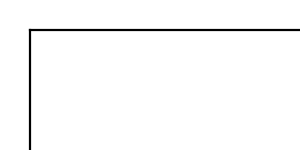

In [12]:
va = VA(DeepSI, samples)

## Run VA with DeepVA and COVID19

In [13]:
# va = VA(DeepVA, samples, learning_rate=3.5e-2)